# Mechanism
- $D$iscriminator classifies real/fake images
- The goal is to train a $G$enerator that generates fake images indistinguishable from real to deceive the discriminator
- Objective function:
\begin{align}
\underset{G}\min \underset{D}\max V(D,G) = E_{x \sim p_{data}(x)}[\log D(x)]+E_{z \sim p_z(z)}[\log (1-D(G(z)))]
\end{align}
- GAN minimizes the distance between the real data distribution and the model distribution

# MNIST
- Train $G$enerator that generates realistic digit images
- Reference: https://github.com/yunjey/pytorch-tutorial

In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [2]:
# preprocess
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5))
])
mnist = datasets.MNIST(root='data/mnist', train=True, transform=transform, download=True)
batch_size = 100
data_loader = torch.utils.data.DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True)

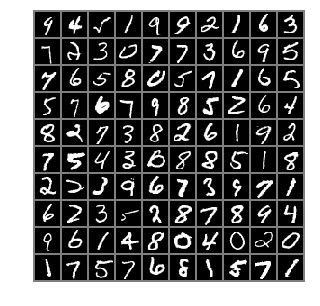

In [3]:
# sample batch
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5, 5)
def imshow(img):
    img = torchvision.utils.make_grid(img, nrow=10) / 2 + 0.5    # 0-1
    npimg = img.numpy()
    plt.figure()    # stacks images vertically if called more than once
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.axis('off')
images, labels = data_loader.__iter__().next()
imshow(images)

In [4]:
# GAN
D = nn.Sequential(
    nn.Linear(784, 256),    # image=28*28
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid()
).cuda()
G = nn.Sequential(
    nn.Linear(64, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 784),
    nn.Tanh()
).cuda()

In [5]:
criterion = nn.BCELoss()    # Binary Cross Entropy
d_optimizer = torch.optim.Adam(D.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(G.parameters(), lr=1e-4)

Epoch=1 D(x)=0.86 D(G(z))=0.15
Epoch=2 D(x)=0.88 D(G(z))=0.16
Epoch=3 D(x)=0.70 D(G(z))=0.29
Epoch=4 D(x)=0.65 D(G(z))=0.46
Epoch=5 D(x)=0.91 D(G(z))=0.09
Epoch=6 D(x)=0.83 D(G(z))=0.13
Epoch=7 D(x)=0.93 D(G(z))=0.15
Epoch=8 D(x)=0.71 D(G(z))=0.25
Epoch=9 D(x)=0.91 D(G(z))=0.11
Epoch=10 D(x)=0.93 D(G(z))=0.09
Epoch=11 D(x)=0.85 D(G(z))=0.11
Epoch=12 D(x)=0.94 D(G(z))=0.10
Epoch=13 D(x)=0.92 D(G(z))=0.06
Epoch=14 D(x)=0.91 D(G(z))=0.10
Epoch=15 D(x)=0.88 D(G(z))=0.15
Epoch=16 D(x)=0.95 D(G(z))=0.14
Epoch=17 D(x)=0.92 D(G(z))=0.05
Epoch=18 D(x)=0.91 D(G(z))=0.13
Epoch=19 D(x)=0.83 D(G(z))=0.16
Epoch=20 D(x)=0.93 D(G(z))=0.05
Epoch=21 D(x)=0.92 D(G(z))=0.13
Epoch=22 D(x)=0.92 D(G(z))=0.17
Epoch=23 D(x)=0.86 D(G(z))=0.11
Epoch=24 D(x)=0.87 D(G(z))=0.13
Epoch=25 D(x)=0.87 D(G(z))=0.07
Epoch=26 D(x)=0.84 D(G(z))=0.05
Epoch=27 D(x)=0.91 D(G(z))=0.09
Epoch=28 D(x)=0.85 D(G(z))=0.05
Epoch=29 D(x)=0.82 D(G(z))=0.10
Epoch=30 D(x)=0.83 D(G(z))=0.14
Epoch=31 D(x)=0.79 D(G(z))=0.07
Epoch=32 D(x)=0.8

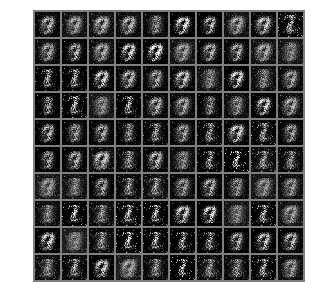

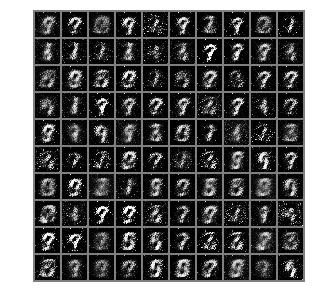

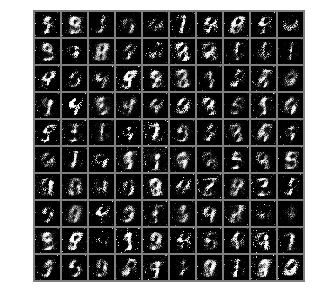

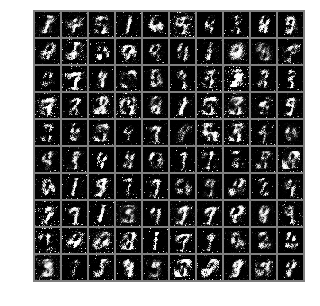

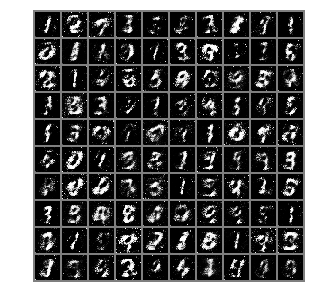

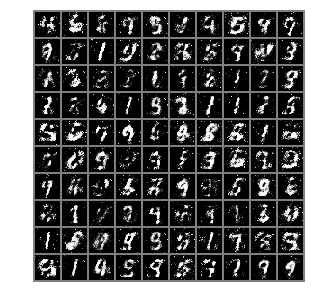

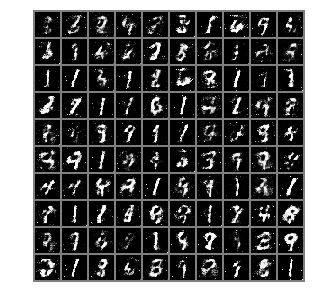

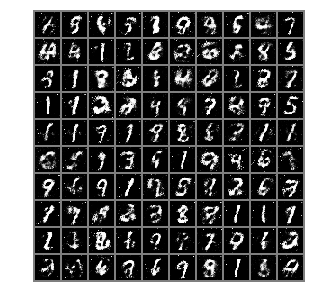

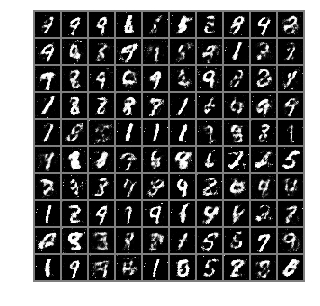

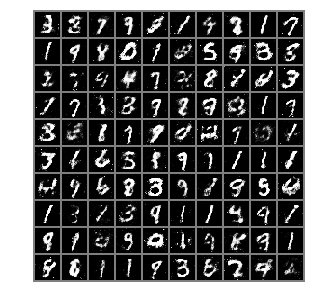

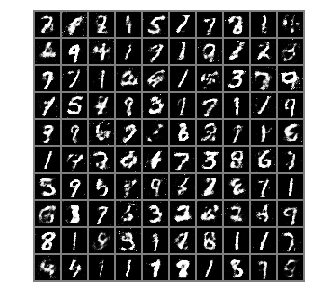

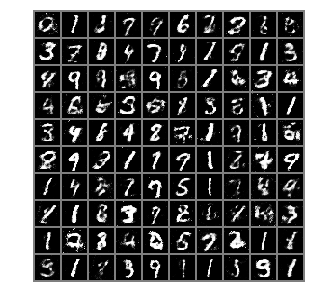

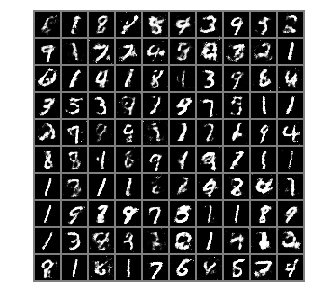

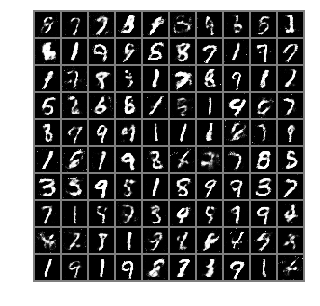

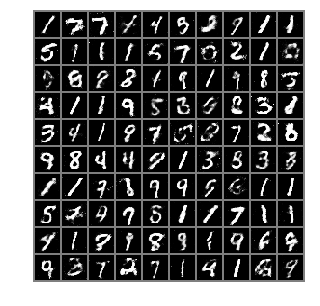

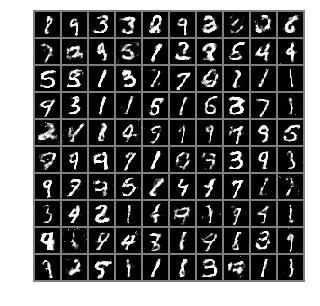

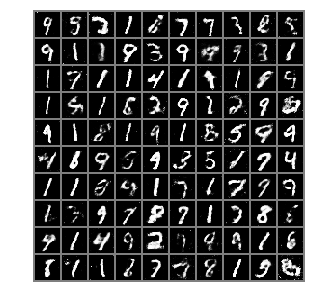

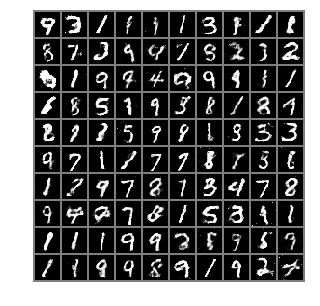

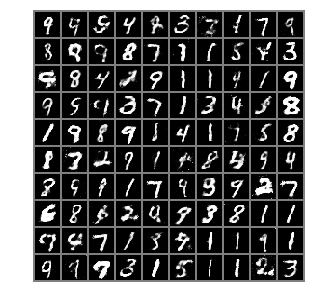

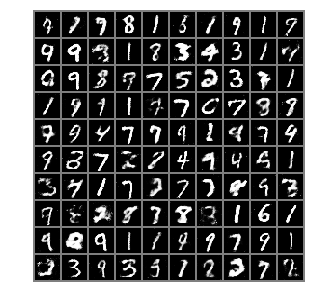

In [6]:
for epoch in range(200):
    for i, (images, labels) in enumerate(data_loader):
        # mini-batch
        x = Variable(images.view(batch_size, -1).cuda())
        ones = Variable(torch.ones(batch_size).cuda())
        zeros = Variable(torch.zeros(batch_size).cuda())
        # train discriminator
        y_real = D(x)
        loss_real = criterion(y_real, ones)
        z = Variable(torch.randn(batch_size, 64).cuda())
        y_fake = D(G(z))
        loss_fake = criterion(y_fake, zeros)
        loss = loss_real + loss_fake
        D.zero_grad()
        loss.backward()
        d_optimizer.step()
        # train generator
        z = Variable(torch.randn(batch_size, 64).cuda())
        y = D(G(z))    # fake images
        loss = criterion(y, ones)
        D.zero_grad()
        G.zero_grad()
        loss.backward()
        g_optimizer.step()
    # debug
    print 'Epoch={} D(x)={:.2f} D(G(z))={:.2f}'.format(epoch+1, y_real.data.mean(), y_fake.data.mean())
    if (epoch+1) % 10 == 0:
        imshow(G(z).view(batch_size, 1, 28, 28).cpu().data)